# Simon's Algorithm

Simon's algorithm is the first quantum algorithm to offer an exponential speedup over the best-known classical algorithm for Simon's problem.

1. [Problem Statement](#1.-Problem-Statement)
2. [Quantum Solution](#2.-Quantum-Solution)
3. [Qiskit Implementation](#3.-Qiskit-Implementation)
4. [Firsthand Experience with ibm_rensselaer](#4.-Firsthand-Experience-with-ibm_rensselaer)

## 1. Problem Statement

Simon's problem involves finding a secret $n$-bit string, $s$, by querying an oracle that maps two distinct inputs to one unique output (a **two-to-one** function). 

The oracle takes an $n$-bit string $x = x_{n-1}\ldots x_1x_0$ as input and outputs an $n$-bit string $f(x)=f_{n-1}\ldots f_1f_0$. The oracle promises that: 

$$f(x)=f(y)$$

where $y = x \oplus s$ and $\oplus$ denotes a bitwise $\text{XOR}$.

In other words, for every output value $f(x)$, there exists exactly two distinct inputs $x$ and $y$ such that their $\text{XOR}$ difference is the unknown string $s$ ($x \oplus  y = s$).

Our goal is to determine the unknown string $s$ by querying the oracle.

### 1.1 Example

Consider the following simple example with $n = 3$ and the secret string $s = 110$.


| $x$  | $f(x\oplus s)$|
| :-:  |     :-:     |
| 000  |     101     |
| 001  |     010     |
| 010  |     011     |
| 011  |     100     |
| 100  |     011     |
| 101  |     100     |
| 110  |     101     |
| 111  |     010     |

Notice that inputs $x = 000$ and $x = 110$ will produce the same output $f(x\oplus s) = 101$. This produces a *collision*, i.e. two inputs map to the same output.

The same relationship exists for $x = 001 = 111$, $x = 010 = 100$, and $x = 011 = 101$.

### 1.2 Classical Solution

If we find a collision, we can find the hidden string $s$ by taking the $\text{XOR}$ of the two inputs: 

$$x \oplus y = 000 \oplus 110 = 110 = s$$

One classical approach is the brute-force method, where you try each input one-by-one to find a collision. In the worst case, you could try half the inputs $(2^{n-1})$ before finding a collision.

For the best randomized classical algorithm, the number of queries is $2^{\frac{n}{2}}$, which is still exponential.

## 2. Quantum Solution

To find the hidden string $s$, Simon's algorithm is required to run at least $n$ times to retrieve different measurements, $\ket{z}$, such that the dot product of $s$ and $z$ is $0$:

$$s \cdot z = 0 \mod 2$$

For Simon's algorithm, we need $n$ input qubits and $n$ answer qubits. In Deutsch's and Bernstein's algorithm, the answer qubits begin in the $\ket{-}$ state. Here, we will begin all qubits in the $\ket{0}$ state. In this example, the secret string $s = 110$.


<center><img src="simons_images/simon_circuit.png"></img></center>

### 2.1 IBM Quantum Composer

IBM Quantum Composer: https://quantum.ibm.com/composer/

#### 2.1.1 Preprocessing

We apply Hadamards to all input qubits. Note that the visualization of the Q-sphere does not work for $5+$ qubits.

<center><img src="simons_images/preprocessing.png"></img></center>

#### 2.1.2 Oracle

Then we apply the oracle such that: $\ket{x}\ket{0}\rightarrow\ket{x}\ket{x\oplus s}$. 

First, we want to copy the inputs to their corresponding output register $\left(\ket{x}\ket{0}\rightarrow\ket{x}\ket{x}\right)$. We do this by applying a CNOT with the input qubit as the control and the output qubit as the target.

<center><img src="simons_images/oracle1.png"></img></center>

Now, there are many ways to implement a two-to-one function. In this approach, we split the inputs into two groups based on the index of a chosen flag bit. For all inputs $x$, if the bit at that index is $1$, we $\text{XOR}$ the input string with $s$. Since we want $s$ to map to the zero string, we identify the index of the first bit in $s$ that is a $1$ to be the flag. 

Given IBM's reverse qubit ordering, the secret string $s = 110 \rightarrow s_{reverse} = 011$. 

In this case, the index of the chosen flag bit would be $2$ $\left(\ket{x}\ket{x}\rightarrow\ket{x}\ket{x\oplus s} \text{ if the chosen bit is 1}\right)$.

| $x$  | $f(x\oplus s)$|
| :-:  |     :-:     |
| 000  |     000     |
| 001  |     001     |
| 010  |     011     |
| 011  |     100     |
| 100  |     011     |
| 101  |     100     |
| 110  |     101     |
| 111  |     010     |


<center><img src="simons_images/oracle2.png"></img></center>

#### 2.1.3 Postprocessing

Finally, apply Hadamards to all input qubits again and measure.

<center><img src="simons_images/postprocessing.png"></img></center>

### 2.2 Classical Postprocessing

We will use the results in the probability distribution to classically find $s$. The results must satisfy:

$$s \cdot z = 0 \mod 2$$

Therefore, we can construct a system of equations to solve for $s$.

$$s \cdot 000 = (s_2 \cdot 0) + (s_1 \cdot 0) + (s_0 \cdot 0) = 0 \mod 2$$ 

$$s \cdot 001 = (s_2 \cdot 0) + (s_1 \cdot 0) + (s_0 \cdot 1) = 0 \mod 2$$ 

$$s \cdot 110 = (s_2 \cdot 1) + (s_1 \cdot 1) + (s_0 \cdot 0) = 0 \mod 2$$ 

$$s \cdot 111 = (s_2 \cdot 1) + (s_1 \cdot 1) + (s_0 \cdot 1) = 0 \mod 2$$ 

From the second equation, we can see $s_0 = 0$.

From the last $2$ equations, we can see $s_2 = s_1 = 0$ $(s = 000)$ or $s_2 = s_1 = 1$  $(s = 110)$. The non-trivial solution gives us $s = 110$, which is our hidden string.

Computationally, we can solve this method with **Gaussian Elimination** with a runtime of $O(n^3)$.

## 3. Qiskit Implementation

### Imports

In [ ]:
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install numpy
%pip install galois

In [1]:
import qiskit
print(qiskit.version.get_version_info())

1.2.4


### 3.1 Circuit Construction

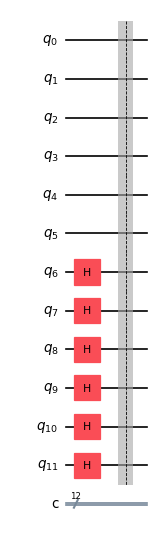

In [2]:
from qiskit import QuantumCircuit

# Preprocessing
# Select a secret bit string
s = '110101'

# Number of qubits to represent s
num_qubits = num_bits = len(s)

# Create a circuit with num_qubits + ancilla, and num_bits
qc = QuantumCircuit(2 * num_qubits, 2 * num_bits)

# Apply Hadamards to all input qubits
qc.h(range(num_qubits, 2 * num_qubits))

qc.barrier()

qc.draw(output="mpl", scale=0.6)

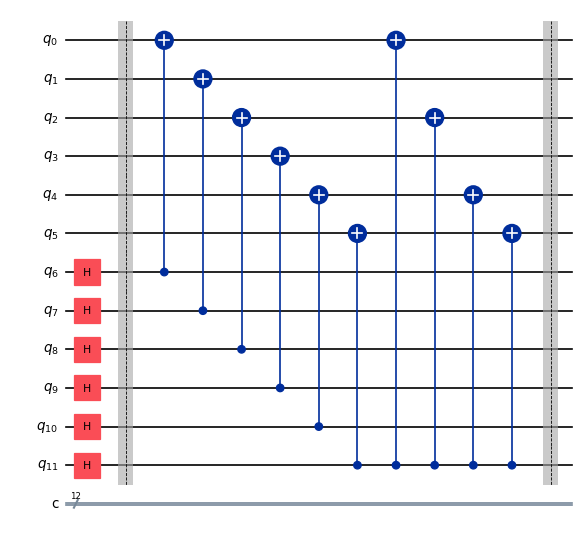

In [3]:
# Oracle        
# Reverse s to fit Qiskit's qubit ordering (bottom up 110101 -> top down 101011)
reverse_s = s[::-1]

flag_bit = reverse_s.find("1")

# |x>|0> -> |x>|x>
# Copy input to output
for q in range(num_qubits):
    qc.cx(q + num_qubits, q)

# |x> -> |x ⊕ s> 
# If there is a found chosen flag bit, apply CNOT with flag as control and 
if flag_bit != -1:
    for q in range(num_qubits):
        if reverse_s[q] == '1':
            qc.cx(2 * num_qubits - (flag_bit + 1), q)

qc.barrier()

qc.draw(output="mpl", scale=0.6)

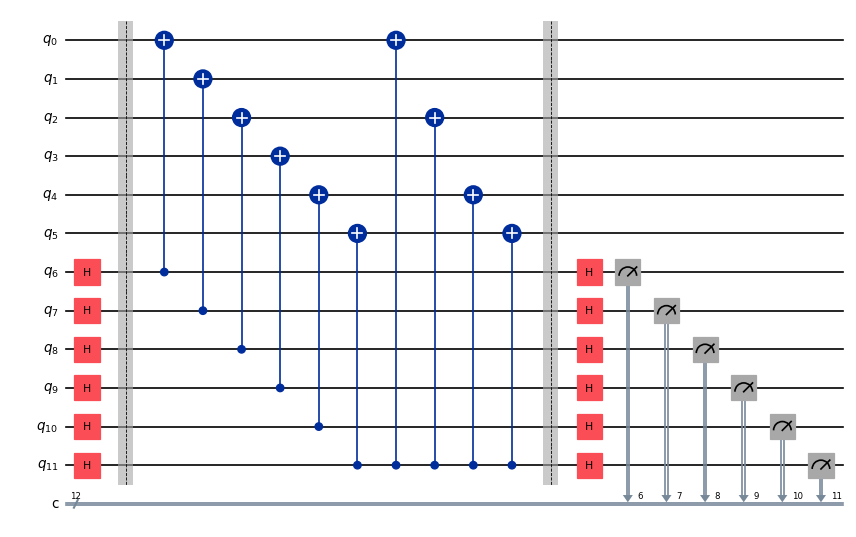

In [4]:
# Post processing and measurement
# Apply Hadamards to all input qubits
qc.h(range(num_qubits, 2 * num_qubits))

# Measure input qubits
for q in range(num_qubits, 2 * num_qubits):
    qc.measure(q, q)

qc.draw(output="mpl", scale=0.6)

### 3.2 Running on a Simulator

First, we initialize a StatevectorSampler primitive that classically simulates the execution of quantum circuits. Then, we run the primitive with $n + 5$ shots and retrieve its results.

The counts are: {'110000000000': 2, '101001000000': 1, '110010000000': 1, '000010000000': 1, '100001000000': 1, '010110000000': 1, '000101000000': 1, '111010000000': 1, '101100000000': 1, '111101000000': 1}


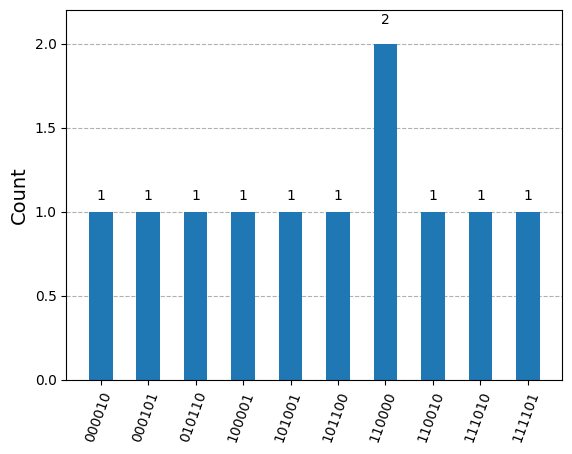

In [5]:
# Running on Simulator
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram

sampler = StatevectorSampler()

sim_qc = qc

# Run using sampler n + 2 times to ensure we have at least n measurements
result = sampler.run([sim_qc], shots=num_qubits + 5).result()

# Get counts for the classical register "c" (Note that the unmeasured qubits remain in the final result)
counts = result[0].data.c.get_counts()
print(f"The counts are: {counts}")

# Remove unmeasured qubits from final result
final_counts = {}
for key, value in counts.items():
    measured = key[:num_qubits]
    final_counts[measured] = value

plot_histogram(final_counts)

### 3.3 Classical Postprocessing

Finally, we prepare the measurements as a matrix of integers, interpret the matrix over $\mathbb{F}_2$​ (the binary field), and compute the null space of the matrix ($A \cdot x = 0$), which corresponds to the solutions of the system of linear equations.

In [6]:
import numpy as np
import galois

# Take only the first n measurements
first_n_measured = dict(list(final_counts.items())[:num_qubits])

# Convert measurements to matrix of integers
matrix = np.array([list(bitstring) for bitstring, count in first_n_measured.items()]).astype(int)

# Find null space (Ax = 0)
null_space = galois.GF(2)(matrix).null_space()

# Convert to string
result = "".join(np.array(null_space[0]).astype(str))

assert(result == s)

print("Result:", result)
print("Hidden bitstring s:", s)

Result: 110101
Hidden bitstring s: 110101


## 4. Firsthand Experience with ibm_rensselaer

As usual, we initialize the ``QiskitRuntimeService`` to interact with IBM Quantum resources.

If you have not already, use the following snippet to log in and save your IBM Quantum account credentials for future use. Replace the ``token`` with your own API token available when you log in at https://quantum.ibm.com/.

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="token",
#     set_as_default=True,
#     # Use 'overwrite=True' if you're updating your token.
#     overwrite=True,
# )

In [12]:
service = QiskitRuntimeService()

# Should be "ibm_rensselaer". If not and you have access to the computer, comment this out and set the backend manually.
# backend = service.least_busy(operational=True, simulator=False)
# print(backend.name)

backend = service.backend("ibm_rensselaer")
print(backend.name)

ibm_rensselaer


We use a preset pass manager with minimal options to transpile our current Simons circuit into the basis gates of the backend we are using, ``ibm_rensselaer``. \
Then, we initialize a Sampler with the backend to execute the circuit on ``ibm_rensselaer``. This can take a couple of minutes or more, depending on the job queue.

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(target=backend.target, optimization_level=1)

isa_circuit = pm.run(qc)
# isa_circuit.draw(output='mpl',scale=0.5)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)

# Use 1000 shots 
job = sampler.run([isa_circuit], shots=1000)
job_result = job.result()
counts = job_result[0].data.c.get_counts()

print(f"The counts are: {counts}")

# Remove unmeasured qubits from final result
final_counts = {}
for key, value in counts.items():
    measured = key[:num_qubits]
    final_counts[measured] = value
    
plot_histogram(final_counts)

After running the circuit, we classically postprocess the results.

In [ ]:
import numpy as np
import galois

# Take only the first n measurements
final_counts = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
first_n_measured = dict(list(final_counts.items())[:num_qubits])

# Convert measurements to matrix of integers
matrix = np.array([list(bitstring) for bitstring, count in first_n_measured.items()]).astype(int)

# Find null space (Ax = 0)
null_space = galois.GF(2)(matrix).null_space()

# Convert to string
result = "".join(np.array(null_space[0]).astype(str))

assert(result == s)

print("Result:", result)
print("Hidden bitstring s:", s)